### Model 1: Failure Prediction
* Problem type: Binary classification (Failure soon = Yes/No).
* Algorithms: Random Forest, Gradient Boosting, Logistic Regression.
* Features: sensor readings (Air temperature, Process temperature, Rotational speed, etc.).
Target: failure flag.
### Model 2: Failure Type Classification
* Problem type: Multi-class classification.
* Algorithms: Decision Tree, SVM, Naive Bayes, XGBoost.
* Target: failure_type (tool wear failure (TWF), heat dissipation failure (HDF), etc.).
Evaluation
### For Model 1: precision-recall (catching failures is critical).
### For Model 2: confusion matrix, per-class F1-scores.
* archive.ics.uci.edu
* UCI Machine Learning Repository
* Discover datasets around the world!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score

# Classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# XGBoost
import xgboost as xgb

In [2]:
# Load the dataset
df = pd.read_csv('ai4i2020.csv')
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [3]:
df.describe

<bound method NDFrame.describe of         UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0         1     M14860    M                298.1                    308.6   
1         2     L47181    L                298.2                    308.7   
2         3     L47182    L                298.1                    308.5   
3         4     L47183    L                298.2                    308.6   
4         5     L47184    L                298.2                    308.7   
...     ...        ...  ...                  ...                      ...   
9995   9996     M24855    M                298.8                    308.4   
9996   9997     H39410    H                298.9                    308.4   
9997   9998     M24857    M                299.0                    308.6   
9998   9999     H39412    H                299.0                    308.7   
9999  10000     M24859    M                299.0                    308.7   

      Rotational speed [rpm]  Torque [Nm]

In [4]:
df.duplicated

<bound method DataFrame.duplicated of         UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0         1     M14860    M                298.1                    308.6   
1         2     L47181    L                298.2                    308.7   
2         3     L47182    L                298.1                    308.5   
3         4     L47183    L                298.2                    308.6   
4         5     L47184    L                298.2                    308.7   
...     ...        ...  ...                  ...                      ...   
9995   9996     M24855    M                298.8                    308.4   
9996   9997     H39410    H                298.9                    308.4   
9997   9998     M24857    M                299.0                    308.6   
9998   9999     H39412    H                299.0                    308.7   
9999  10000     M24859    M                299.0                    308.7   

      Rotational speed [rpm]  Torque 

In [6]:
df.isna().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [7]:
# Checking how many 0s and 1s exist in the 'Machine failure' column 
df['Machine failure'].value_counts(normalize=False)


Machine failure
0    9661
1     339
Name: count, dtype: int64

In [8]:
# List of possible failure type columns
failure_cols = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Function to return the first failure type found, else 'No Failure'
def detect_failure(row):
    for col in failure_cols:
        if row[col] == 1:
            return col
    return "No Failure"

# Apply function to create a single categorical column
df['failure_type'] = df.apply(detect_failure, axis=1)

# Check frequency of each class
df['failure_type'].value_counts()


failure_type
No Failure    9652
HDF            115
PWF             91
OSF             78
TWF             46
RNF             18
Name: count, dtype: int64

In [9]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Convert categorical 'Type' into numeric codes
encoder = LabelEncoder()
df['Type_num'] = encoder.fit_transform(df['Type'])

# Select input features
features = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]',
    'Type_num'
]

X = df[features]          # Feature matrix
y = df['Machine failure'] # Target variable (binary)

# Normalize numerical features for better model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training & testing sets (stratified for class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


## Problem type: Binary classification

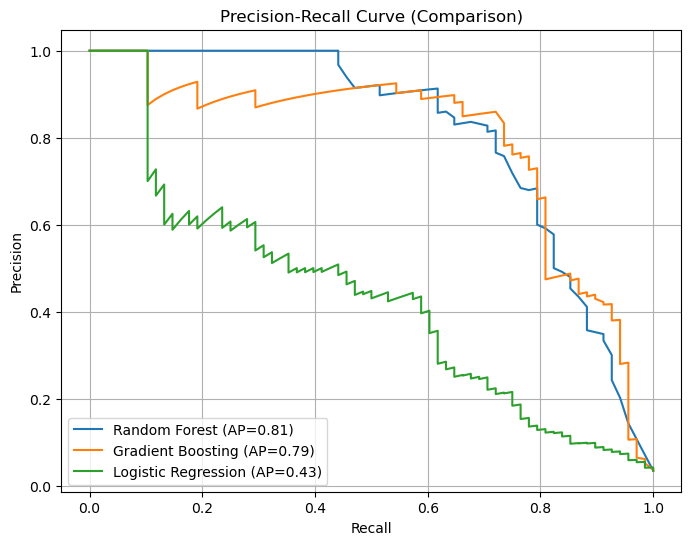

In [10]:
# Define classifiers to compare
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression()
}

# Plot Precision-Recall curves
plt.figure(figsize=(8, 6))
for clf_name, clf in classifiers.items():
    clf.fit(X_train, y_train)  # Train model
    y_scores = clf.predict_proba(X_test)[:, 1]  # Probabilities for class 1
    
    prec, rec, _ = precision_recall_curve(y_test, y_scores)
    avg_prec = average_precision_score(y_test, y_scores)
    
    plt.plot(rec, prec, label=f"{clf_name} (AP={avg_prec:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Comparison)")
plt.legend()
plt.grid(True)
plt.show()


## Problem type: Multi-class classification.

In [11]:
# Keep only rows where a machine failure occurred
failures_only = df[df['Machine failure'] == 1].copy()

# Features and target for multi-class classification
X_multi = failures_only[features]          # reuse feature columns
y_multi = failures_only['failure_type']    # multi-class labels

# Encode target labels into integers
from sklearn.preprocessing import LabelEncoder
lbl_encoder = LabelEncoder()
y_multi_enc = lbl_encoder.fit_transform(y_multi)

# Standardize feature values
X_multi_scaled = scaler.fit_transform(X_multi)

# Split into train & test sets (stratified by failure type)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_multi_scaled, y_multi_enc, test_size=0.2, stratify=y_multi_enc, random_state=42
)


## train mode (Multi-class classification.)


=== Decision Tree Report ===

              precision    recall  f1-score   support

         HDF       0.76      0.96      0.85        23
  No Failure       1.00      0.50      0.67         2
         OSF       0.77      0.62      0.69        16
         PWF       0.89      0.94      0.92        18
         TWF       0.83      0.56      0.67         9

    accuracy                           0.81        68
   macro avg       0.85      0.72      0.76        68
weighted avg       0.81      0.81      0.80        68



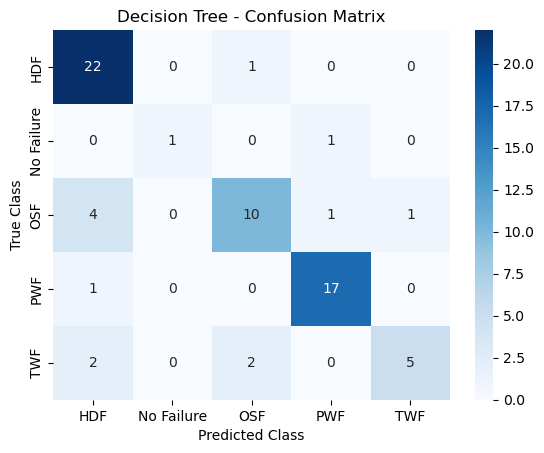


=== Naive Bayes Report ===

              precision    recall  f1-score   support

         HDF       0.69      0.96      0.80        23
  No Failure       0.00      0.00      0.00         2
         OSF       0.80      0.75      0.77        16
         PWF       0.80      0.67      0.73        18
         TWF       0.83      0.56      0.67         9

    accuracy                           0.75        68
   macro avg       0.62      0.59      0.59        68
weighted avg       0.74      0.75      0.73        68



C:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


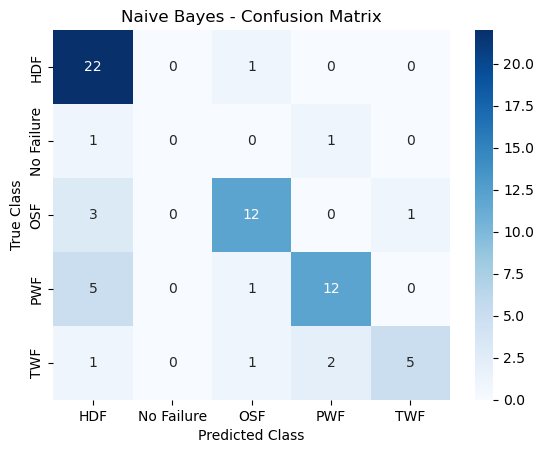


=== SVM Report ===

              precision    recall  f1-score   support

         HDF       0.77      1.00      0.87        23
  No Failure       0.00      0.00      0.00         2
         OSF       0.78      0.88      0.82        16
         PWF       0.79      0.61      0.69        18
         TWF       1.00      0.67      0.80         9

    accuracy                           0.79        68
   macro avg       0.67      0.63      0.64        68
weighted avg       0.78      0.79      0.78        68



C:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


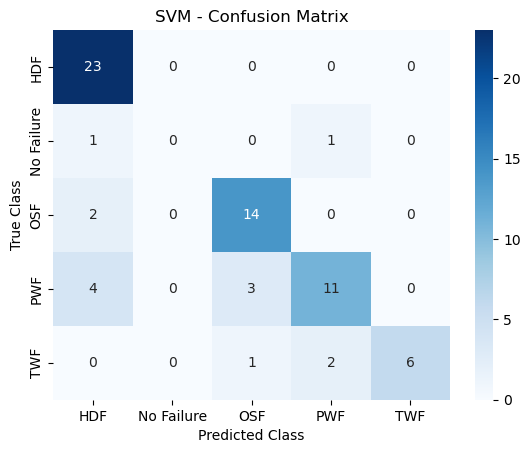

C:\Users\bbuser\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:21:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost Report ===

              precision    recall  f1-score   support

         HDF       0.88      1.00      0.94        23
  No Failure       1.00      1.00      1.00         2
         OSF       0.85      0.69      0.76        16
         PWF       0.95      1.00      0.97        18
         TWF       0.88      0.78      0.82         9

    accuracy                           0.90        68
   macro avg       0.91      0.89      0.90        68
weighted avg       0.89      0.90      0.89        68



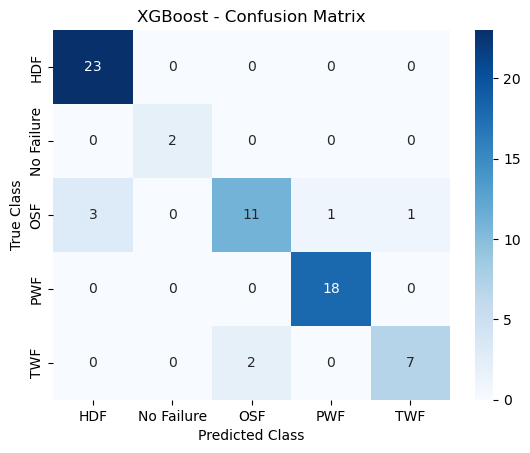

In [12]:
# Define multiple classifiers for multi-class comparison
multi_classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True),
    "XGBoost": xgb.XGBClassifier(eval_metric="mlogloss", use_label_encoder=False)
}

# Train, predict, and evaluate each model
for clf_name, clf in multi_classifiers.items():
    clf.fit(X_train_m, y_train_m)
    y_pred_m = clf.predict(X_test_m)

    # Print classification report
    print(f"\n=== {clf_name} Report ===\n")
    print(classification_report(y_test_m, y_pred_m, target_names=lbl_encoder.classes_))

    # Confusion matrix visualization
    cmatrix = confusion_matrix(y_test_m, y_pred_m)
    sns.heatmap(
        cmatrix, annot=True, fmt="d",
        xticklabels=lbl_encoder.classes_,
        yticklabels=lbl_encoder.classes_,
        cmap="Blues"
    )
    plt.title(f"{clf_name} - Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()
